# 数据预处理
将图片缩放到 1024 * 768

In [10]:
from pathlib import Path
test_img_path = Path('./datasets/')
clothes_img_list = [str(i) for i in list(test_img_path.rglob('test/cloth/*.jpg'))]
person_img_list = [str(i) for i in list(test_img_path.rglob('test/image/*.jpg'))]
clothes_edge_img_list = [str(i) for i in list(test_img_path.rglob('test/cloth-mask/*.jpg'))]
print("clothes_img_list:", clothes_img_list)
print("person_img_list:", person_img_list)
print("clothes_edge_img_list:", clothes_edge_img_list)

clothes_img_list: ['datasets/test/cloth/00001.jpg']
person_img_list: ['datasets/test/image/10549_00.jpg', 'datasets/test/image/m_00001.jpg', 'datasets/test/image/m_00002.jpg']
clothes_edge_img_list: ['datasets/test/cloth-mask/00001.jpg']


In [11]:
import cv2
for p in person_img_list:
    print(p)
    p_img = cv2.imread(p)
    print(p_img.shape)
    # 注意 opencv resize 的 size 是: (w, h)
    p_img = cv2.resize(p_img, (768, 1024), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(p, p_img)

datasets/test/image/10549_00.jpg
(1024, 768, 3)
datasets/test/image/m_00001.jpg
(1024, 768, 3)
datasets/test/image/m_00002.jpg
(1024, 768, 3)


## OpenPose 生成人体姿态/躯干

In [1]:
%cd /home/jiaqianjing/workspace/search/gans/openpose
! cat run.sh
! sh run.sh
%cd -

/home/jiaqianjing/workspace/search/gans/openpose
#!/bin/bash
# ==================================================================
# hand: 是否检测手部细节关键点信息
# face: 是否检测面部细节的关键点信息
# image_dir: 待提取姿态关键点信息的原始图像目录
# write_images: 输出目录
# write_images_format: 输出图片的文件格
# write_json: 以 json 的格式保存关键点信息，格式为：(x, y, confidence)
# display: 执行完成后是否通过显示设备展示结果, 0: 不展示 1: 展示
# render_pose: 是否渲染骨架信息,混合到原始图上, 0:不渲染，直接输出原始图像 1: 渲染骨架信息并叠加到原始图像
# disable_blending: 关闭渲染的骨架信息和原始图像混合，只生成关键点骨架信息
# ==================================================================
img_dir='/home/jiaqianjing/workspace/search/gans/VITON-HD/datasets/test/image'
output_images='/home/jiaqianjing/workspace/search/gans/VITON-HD/datasets/test/openpose-img'
output_jsons='/home/jiaqianjing/workspace/search/gans/VITON-HD/datasets/test/openpose-json'
./build/examples/openpose/openpose.bin --hand \
	--face \
	--image_dir $img_dir \
	--write_images $output_images \
	--write_images_format png \
	--write_json $output_jsons \
	--display 0 \
	--rende

## 生成 Human Parsing (semantic segmentation)

In [5]:
%cd /home/jiaqianjing/workspace/search/gans/CIHP_PGN/
!/root/miniconda3/envs/tf1.15/bin/python predict.py
%cd -

/home/jiaqianjing/workspace/search/gans/CIHP_PGN
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

image_list: ['../../gans/VITON-HD/datasets/test/image/10549_00.jpg', '../../gans/VITON-HD/datasets/test/image/m_00001.jpg', '../../gans/VITON-HD/datasets/test/image/m_00002.jpg']
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).re

# 浏览测试数据(Input Data)

In [14]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def show_imgs(imgs, horizon=True, h=24, w=12):
    plt.figure(figsize=(h, w), dpi=32)
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name)

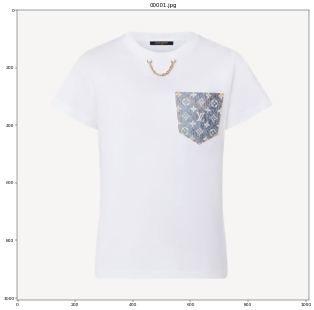

In [15]:
# Garment
show_imgs(clothes_img_list)

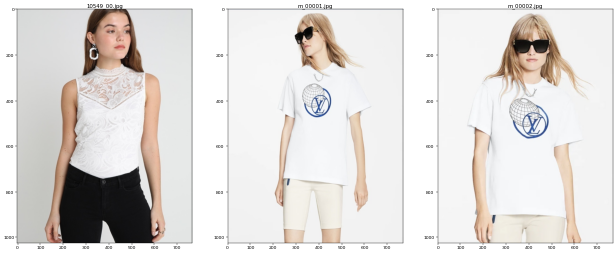

In [16]:
# Person
show_imgs(person_img_list)

# Virtual Try-On

In [17]:
!rm -rf ./results/
!python test.py --name demo

Namespace(alias_checkpoint='alias_final.pth', batch_size=1, checkpoint_dir='./checkpoints/', dataset_dir='./datasets/', dataset_list='test_pairs.txt', dataset_mode='test', display_freq=1, gmm_checkpoint='gmm_final.pth', grid_size=5, init_type='xavier', init_variance=0.02, load_height=1024, load_width=768, name='demo', ngf=64, norm_G='spectralaliasinstance', num_upsampling_layers='most', save_dir='./results/', seg_checkpoint='seg_final.pth', semantic_nc=13, shuffle=False, workers=1)
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type In

# result

In [18]:
result_img_path = Path('./results/')
res_imgs = [ str(i) for i in result_img_path.rglob('demo/*.jpg')]
print(res_imgs)

['results/demo/m_00001.jpg', 'results/demo/10549_00001.jpg']


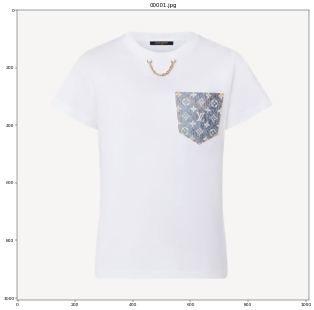

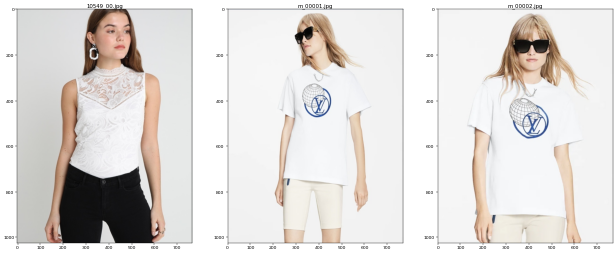

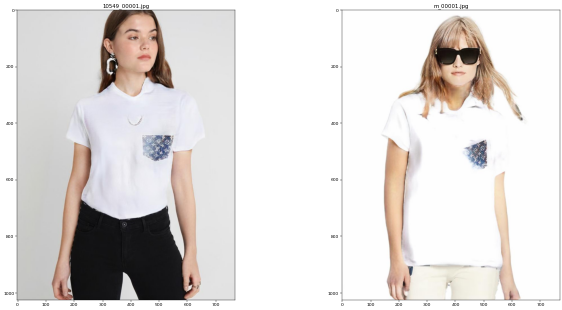

In [19]:
show_imgs(sorted(clothes_img_list))
show_imgs(sorted(person_img_list))
show_imgs(sorted(res_imgs))